## **Section 5.3: Attack Success**

- Using simulations based on our Tor crawls from section 4 with injection rate 3, we assess the success of our guard discovery attack.
- With this notebook, figure 4 and table 4 in our paper can be obtained.

In [1]:
import re
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from glob import glob
from datetime import datetime
from os.path import join, abspath
from matplotlib.lines import Line2D

In [2]:
DATA_DIR = abspath("./2_data_attack-time")

In [3]:
def load_from_json(json_path):
    return json.loads(open(json_path).read())


def load_sim_results(json_path, attack_times):

    # Load simulation result JSON.
    res = load_from_json(json_path)

    # Pretty-format the adversary-controlled share of HSDirs.
    h = "-1"
    if res["n_adv_hsdirs"] == 1:
        h = "1/6"
    elif res["n_adv_hsdirs"] == 2:
        h = "1/3"
    elif res["n_adv_hsdirs"] == 6:
        h = "1"

    # Pretty-format the adversarial relay bandwidth share.
    b = "%d%%" % (100 * float(res["adv_bw_share"]))

    # Extract the initialization value for the token bucket.
    tb_iv = res["n_initial_tokens"]

    # Extract the refill rate for the token bucket.
    tb_refill = res["token_refill_rate"]

    # Extract whether Vanguards-lite was enabled.
    vanguardslite_enabled = False
    if "vanguardslite_enabled" in res:
        vanguardslite_enabled = res["vanguardslite_enabled"]

    simulation_duration = res["simulation_duration"]

    # Append each attack duration with attached metadata to list of all results.
    for timestamp in res["attack_durations"]:
        attack_times.append(
            (h, b, tb_iv, tb_refill, vanguardslite_enabled, timestamp))


def load_sim_rates(txt_path):
    """Loads various accuracy metrics for a simulation result file."""

    rates = []

    with open(txt_path) as rates_fp:
        rates_file_raw = rates_fp.read().splitlines()

    for line in rates_file_raw:

        if line.startswith("Runs:"):

            h_raw = float(re.search("\\(h:\\s+(\\d\\.\\d\\d),", line).group(1))
            b_raw = float(re.search("bw:\\s+(\\d\\.\\d\\d),", line).group(1))

            tb_iv = int(re.search("tb_iv:\\s+(\\d+),", line).group(1))
            tb_rr = float(
                re.search(
                    "tb_rr:\\s+(\\d+\\.\\d+)\\)",
                    line).group(1))

            fp_single = re.search(
                "\\(FP-single:\\s+(\\d+\\.\\d+%)\\)",
                line).group(1)

            tp = re.search("T:\\s+(\\d+\\.\\d+%)\\s", line).group(1)
            fp = re.search("F:\\s+(\\d+\\.\\d+%)\\s", line).group(1)
            nocall = re.search("Nocall:\\s+(\\d+\\.\\d+%)$", line).group(1)

            if h_raw == 0.17:
                h = "1/6"
            elif h_raw == 0.33:
                h = "1/3"
            elif h_raw == 1.0:
                h = "1"

            b = "%d%%" % (100 * b_raw)

            rates.append((h, b, tb_iv, tb_rr, fp_single, tp, fp, nocall))

    return rates

In [4]:
sim_times_path = join(DATA_DIR, "time_to_double_comp_*.json")
sim_rates_path = join(DATA_DIR, "attack-success_sim.log")

attack_times = []
for json_path in glob(sim_times_path):
    load_sim_results(json_path, attack_times)

sim_rates = load_sim_rates(sim_rates_path)

In [5]:
# 2,867 (experiments) * 100 (repetitions) * 9 (settings) = 2,580,300.
len(attack_times)

2580300

In [6]:
df = pd.DataFrame(attack_times, columns=["h", "b", "tb_iv", "tb_refill", "vanguardslite_enabled", "attack_duration"])
df.head(20)

,h,b,tb_iv,tb_refill,vanguardslite_enabled,attack_duration
0,1/6,1%,0,0,False,9.734500
1,1/6,1%,0,0,False,101.337907
2,1/6,1%,0,0,False,15.010500
3,1/6,1%,0,0,False,81.570456
4,1/6,1%,0,0,False,136.066606
5,1/6,1%,0,0,False,19.876000
6,1/6,1%,0,0,False,11.658000
7,1/6,1%,0,0,False,111.260393
8,1/6,1%,0,0,False,76.221616
9,1/6,1%,0,0,False,79.709990


In [7]:
assert df["vanguardslite_enabled"].any() == False
assert df["vanguardslite_enabled"].all() == False
assert df["tb_iv"].astype(bool).any() == False
assert df["tb_iv"].astype(bool).all() == False
assert df["tb_refill"].astype(bool).any() == False
assert df["tb_refill"].astype(bool).all() == False

In [8]:
# Estimation of number of generated noise lookups.
SIM_DURATION = 300.0
SIM_NOISE_LOOKUPS_PER_S = 1052.27
SIM_N_RELAY_CACHE_BUFFER = 100

SIM_NUM_NOISE_LOOKUPS_PER_EXP = (SIM_NOISE_LOOKUPS_PER_S * SIM_DURATION) + SIM_N_RELAY_CACHE_BUFFER
SIM_NUM_NOISE_LOOKUPS = SIM_NUM_NOISE_LOOKUPS_PER_EXP * len(attack_times)

print("SIM_NUM_NOISE_LOOKUPS_PER_EXP:", SIM_NUM_NOISE_LOOKUPS_PER_EXP)
print("SIM_NUM_NOISE_LOOKUPS:", SIM_NUM_NOISE_LOOKUPS)

SIM_NUM_NOISE_LOOKUPS_PER_EXP: 315781.0
SIM_NUM_NOISE_LOOKUPS: 814809714300.0


## Table 4

In [9]:
df_desc = pd.DataFrame(df.groupby(["h", "b"]).attack_duration.describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.95, 0.99]))
df_desc.head(20)

count        mean        std     min        25%        50%  \
h   b                                                                   
1   1%  286700.0   20.651478  21.437353  0.7640  11.518000  16.367000   
    2%  286700.0   12.736200  13.555169  0.3705   7.872500  10.904000   
    5%  286700.0    7.678904   7.513186  0.4230   4.914375   6.714500   
1/3 1%  286700.0   57.840842  52.200265  1.0715  23.748375  39.887750   
    2%  286700.0   29.263373  29.209211  0.7130  14.590500  21.688250   
    5%  286700.0   14.299614  15.269692  0.3395   8.698000  12.056000   
1/6 1%  286700.0  111.972356  82.991669  1.5645  45.091000  88.624136   
    2%  286700.0   57.929581  52.255489  1.2335  23.896000  39.975500   
    5%  286700.0   23.969689  24.566186  0.5900  12.761875  18.471000   

               75%         90%         95%         99%         max  
h   b                                                               
1   1%   23.493000   33.590000   43.438575   91.487557  302.542075  
    2%   14.666000   19.348500   23.340550   40.201120  301.042075  
    5%    8.976000   11.518500   13.598000   24.074040  300.000000  
1/3 1%   74.318208  121.152953  162.611952  300.000000  302.542075  
    2%   33.132000   52.493550   74.757398  144.842421  301.478050  
    5%   16.422500   22.010000   26.784500   48.559595  302.734910  
1/6 1%  155.948131  254.071144  300.000000  300.000000  301.833356  
    2%   74.292856  121.308635  163.065827  300.000000  301.534909  
    5%   27.127500   40.030050   54.647750  112.918515  302.529443

In [10]:
df_rates = pd.DataFrame(sim_rates, columns=["h", "b", "tb_iv", "tb_rr", "fp_single", "tp", "fp", "nocall"])
df_rates.head(20)

,h,b,tb_iv,tb_rr,fp_single,tp,fp,nocall
0,1,1%,0,0.0,19.73%,99.42%,0.37%,0.21%
1,1/3,1%,0,0.0,19.68%,98.85%,0.15%,1.00%
2,1/6,1%,0,0.0,20.22%,93.10%,0.08%,6.82%
3,1,2%,0,0.0,19.61%,99.63%,0.30%,0.06%
4,1/3,2%,0,0.0,19.50%,99.50%,0.14%,0.37%
5,1/6,2%,0,0.0,19.68%,98.90%,0.08%,1.02%
6,1,5%,0,0.0,19.49%,99.75%,0.24%,0.01%
7,1/6,5%,0,0.0,19.42%,99.63%,0.09%,0.28%
8,1/3,5%,0,0.0,19.41%,99.78%,0.13%,0.09%


In [11]:
df_table = pd.merge(df_desc, df_rates, on = ["h", "b"])
df_table.head(20)

,h,b,count,mean,std,min,25%,50%,75%,90%,95%,99%,max,tb_iv,tb_rr,fp_single,tp,fp,nocall
0,1,1%,286700.0,20.651478,21.437353,0.7640,11.518000,16.367000,23.493000,33.590000,43.438575,91.487557,302.542075,0,0.0,19.73%,99.42%,0.37%,0.21%
1,1,2%,286700.0,12.736200,13.555169,0.3705,7.872500,10.904000,14.666000,19.348500,23.340550,40.201120,301.042075,0,0.0,19.61%,99.63%,0.30%,0.06%
2,1,5%,286700.0,7.678904,7.513186,0.4230,4.914375,6.714500,8.976000,11.518500,13.598000,24.074040,300.000000,0,0.0,19.49%,99.75%,0.24%,0.01%
3,1/3,1%,286700.0,57.840842,52.200265,1.0715,23.748375,39.887750,74.318208,121.152953,162.611952,300.000000,302.542075,0,0.0,19.68%,98.85%,0.15%,1.00%
4,1/3,2%,286700.0,29.263373,29.209211,0.7130,14.590500,21.688250,33.132000,52.493550,74.757398,144.842421,301.478050,0,0.0,19.50%,99.50%,0.14%,0.37%
5,1/3,5%,286700.0,14.299614,15.269692,0.3395,8.698000,12.056000,16.422500,22.010000,26.784500,48.559595,302.734910,0,0.0,19.41%,99.78%,0.13%,0.09%
6,1/6,1%,286700.0,111.972356,82.991669,1.5645,45.091000,88.624136,155.948131,254.071144,300.000000,300.000000,301.833356,0,0.0,20.22%,93.10%,0.08%,6.82%
7,1/6,2%,286700.0,57.929581,52.255489,1.2335,23.896000,39.975500,74.292856,121.308635,163.065827,300.000000,301.534909,0,0.0,19.68%,98.90%,0.08%,1.02%
8,1/6,5%,286700.0,23.969689,24.566186,0.5900,12.761875,18.471000,27.127500,40.030050,54.647750,112.918515,302.529443,0,0.0,19.42%,99.63%,0.09%,0.28%


In [12]:
# This is the raw form of Table 4 in the paper.

print(df_table.to_latex(columns=["h", "b", "min", "25%", "50%", "75%", "90%", "99%", "tp", "fp", "nocall"],
                        index=False, multirow=False, float_format="{:0.2f}".format))

\begin{tabular}{llrrrrrrlll}
\toprule
  h &  b &  min &   25\% &   50\% &    75\% &    90\% &    99\% &     tp &    fp & nocall \\
\midrule
  1 & 1\% & 0.76 & 11.52 & 16.37 &  23.49 &  33.59 &  91.49 & 99.42\% & 0.37\% &  0.21\% \\
  1 & 2\% & 0.37 &  7.87 & 10.90 &  14.67 &  19.35 &  40.20 & 99.63\% & 0.30\% &  0.06\% \\
  1 & 5\% & 0.42 &  4.91 &  6.71 &   8.98 &  11.52 &  24.07 & 99.75\% & 0.24\% &  0.01\% \\
1/3 & 1\% & 1.07 & 23.75 & 39.89 &  74.32 & 121.15 & 300.00 & 98.85\% & 0.15\% &  1.00\% \\
1/3 & 2\% & 0.71 & 14.59 & 21.69 &  33.13 &  52.49 & 144.84 & 99.50\% & 0.14\% &  0.37\% \\
1/3 & 5\% & 0.34 &  8.70 & 12.06 &  16.42 &  22.01 &  48.56 & 99.78\% & 0.13\% &  0.09\% \\
1/6 & 1\% & 1.56 & 45.09 & 88.62 & 155.95 & 254.07 & 300.00 & 93.10\% & 0.08\% &  6.82\% \\
1/6 & 2\% & 1.23 & 23.90 & 39.98 &  74.29 & 121.31 & 300.00 & 98.90\% & 0.08\% &  1.02\% \\
1/6 & 5\% & 0.59 & 12.76 & 18.47 &  27.13 &  40.03 & 112.92 & 99.63\% & 0.09\% &  0.28\% \\
\bottomrule
\end{tabular}



## Figure 4

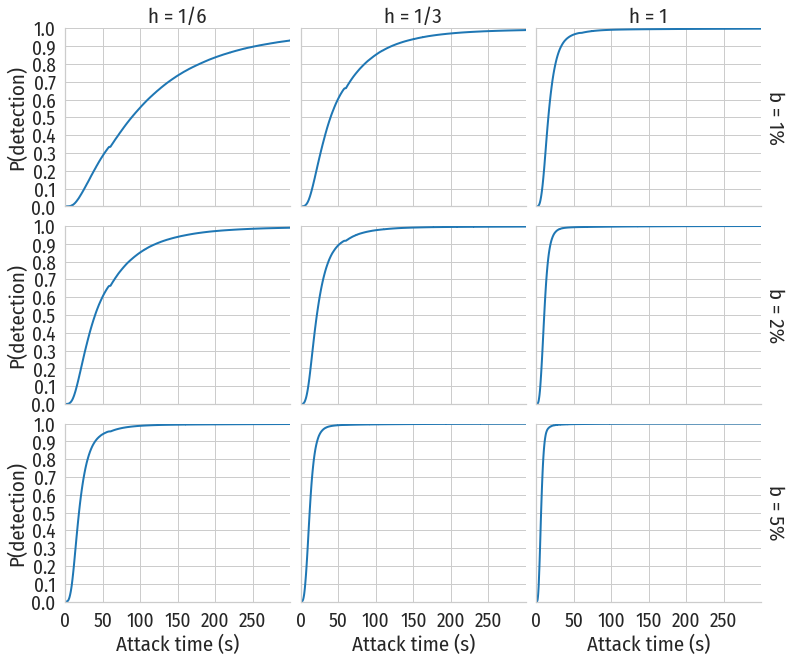

In [13]:
SIMULATION_DURATION = 299.9

sns.set()
sns.set(style="whitegrid", font_scale=1.75)
sns.set_style({"font.family": "Fira Sans Condensed"})

fig = sns.displot(
    df, x = "attack_duration", row = "b", col = "h",
    kind = "ecdf", height = 3.0, aspect = 1.2,
    facet_kws = dict(margin_titles=True), lw = 2.0,
    row_order = ("1%", "2%", "5%"), col_order = ("1/6", "1/3", "1"),
    color = "tab:blue",
)

fig.set_axis_labels(x_var = "Attack time (s)", y_var = "P(detection)")
fig.set_titles("")

fig.set(xlim=(0.0, SIMULATION_DURATION), ylim=(0.0, 1.0),
        xticks=np.arange(0.0, SIMULATION_DURATION, 50.0),
        yticks=np.arange(0.0, 1.1, 0.1))

plt.tight_layout(pad = 0.0, w_pad = 0.25, h_pad = 0.0)

plt.show()